In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
import nibabel as nib
import numpy.ma as ma
from numpy import savetxt
import os
#set up working directories
outDir = '/host/percy/local_raid/hans/amyg/hist/outputs/'

In [2]:
##set up workling directories
outDir = '/data_/mica1/03_projects/hans/BIGBRAIN/outputs/'
figDir = '/data_/mica1/03_projects/hans/BIGBRAIN/figures/'
outDir2= '/host/percy/local_raid/jessica/amygdala/outputs/'
workDir4='/data_/mica1/04_data/16_bigBrain_EC/'

In [3]:
#input variables
res='100'
side='L'

In [21]:
#create matrix with corresponding coordinates for each U1/2 values of cropped 1 in every 5x5x5
mapNif1 = nib.load(outDir+'tpl-icbm_desc-U1_ero5_1sd.nii')
mapU1 = np.array(mapNif1.dataobj)
mapNif2 = nib.load(outDir+'tpl-icbm_desc-U2_ero5_1sd.nii')
mapU2 = np.array(mapNif2.dataobj)

#mapNif1 = nib.load(outDir+'amyg_'+side+'_'+res+'um_u1_cropped_5_ero5_1sd.nii.gz')
#mapU1 = np.array(mapNif1.dataobj)
#mapNif2 = nib.load(outDir+'amyg_'+side+'_'+res+'um_u2_cropped_5_ero5_1sd.nii.gz')
#mapU2 = np.array(mapNif2.dataobj)


coords=np.zeros((12214,5))
num=0
for i in range(len(mapU1[:,1,1])):
    for j in range(len(mapU1[1,:,1])):
        for k in range(len(mapU1[1,1,:])):
            if mapU1[i,j,k] != 0:
                coords[num,0]=i
                coords[num,1]=j
                coords[num,2]=k
                coords[num,3]=mapU1[i,j,k]
                coords[num,4]=mapU2[i,j,k]
                num=num+1
print(num)

12214


In [22]:
import numexpr as ne
list_a = coords[:,0:3]
U1 = coords[:,3]

#print(list_a)

def numexpr_based_with_slicing(A,B):
    a0 = A[...,0]
    a1 = A[...,1]
    b0 = B[...,0]
    b1 = B[...,1]
    return ne.evaluate('sqrt((a0-b0)**2 + (a1-b1)**2)')

def run_euc(list_a,list_b):
    return np.array([[ numexpr_based_with_slicing(i,j) for j in list_b] for i in list_a])

D = run_euc(list_a, list_a)
print(len(D))

12214


In [23]:
dM=D

In [24]:
Dsort= np.argsort(D, axis=1)

In [25]:
from brainspace.null_models import SampledSurrogateMaps
X=coords[:,0]
Y=coords[:,1]
Z=coords[:,2]
U2 = coords[:,4]
ssm = SampledSurrogateMaps(ns=3000, knn=1500, random_state=0)
ssm.fit(D,Dsort)

SampledSurrogateMaps(b=2.462214450449026, deltas=array([0.3, 0.5, 0.7, 0.9]),
                     kernel=<function exp at 0x7faee9becd40>, knn=1500, ns=3000,
                     random_state=0)

In [68]:
from brainspace.null_models import SampledSurrogateMaps
X=coords[:,0]
Y=coords[:,1]
Z=coords[:,2]
U2 = coords[:,4]
ns = [500,1000,1500,2000,2500,3000,3500,4000,4500,5500,6500]
knn = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
#ssm = np.zeros(len(ns)*len(knn))
i=0
#for nsamp in ns:
#    for knearn in knn:
#        ssm[i] = SampledSurrogateMaps(ns=nsamp, knn=knearn, random_state=0)
#        ssm[i].fit(D,Dsort)
#        i=i+1
        
ssm = SampledSurrogateMaps(ns=3000, knn=6000, random_state=0)
ssm.fit(D,Dsort)

SampledSurrogateMaps(b=7.315437444199766, deltas=array([0.3, 0.5, 0.7, 0.9]),
                     kernel=<function exp at 0x7fcd48163050>, knn=6000, ns=3000,
                     random_state=0)

In [26]:
from scipy.stats import spearmanr
U2=coords[:,4]
U1=coords[:,3]
X_surrogates = ssm.randomize(X, n_rep=1000)
Y_surrogates = ssm.randomize(Y, n_rep=1000)
Z_surrogates = ssm.randomize(Z, n_rep=1000)


X:
 Obs      : 2.26059e-196
 Variogram: 8.00000e-03

Y:
 Obs      : 1.07614e-217
 Variogram: 2.00000e-03

Z:
 Obs      : 1.30251e-01
 Variogram: 9.09000e-01



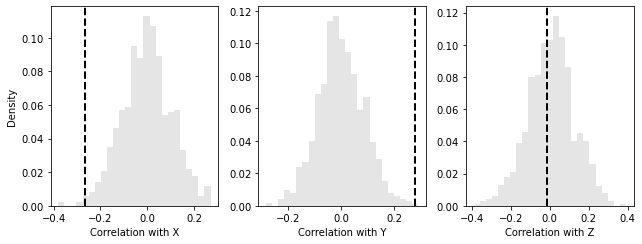

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3.5))

feats = {'X': X, 'Y': Y, 'Z':Z}
rand = {'X': X_surrogates, 'Y': Y_surrogates, 'Z': Z_surrogates}
pv_obs=1
for k, (fn, data) in enumerate(rand.items()):
    r_obs,pv_obs = spearmanr(feats[fn], U2, nan_policy='omit')

    # Compute perm pval
    r_rand = np.asarray([spearmanr(U2, d)[0] for d in data])
    pv_rand = np.mean(np.abs(r_rand) >= np.abs(r_obs))

    # Plot null dist
    weights = np.ones_like(r_rand) / (len(r_rand))
    axs[k].hist(r_rand, bins=25, density=False,weights=weights, alpha=0.5, color=(.8, .8, .8))
    axs[k].axvline(r_obs, lw=2, ls='--', color='k')
    axs[k].set_xlabel(f'Correlation with {fn}')
    if k == 0:
        axs[k].set_ylabel('Density')

    print(f'{fn.capitalize()}:\n Obs      : {pv_obs:.5e}\n '
          f'Variogram: {pv_rand:.5e}\n')
    #print(r_rand[:10])
fig.tight_layout()
plt.show()
fig.savefig("variagram_U2_amyg_ero5_1sd")

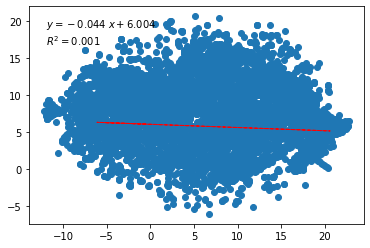

In [83]:
from sklearn.metrics import r2_score

plt.scatter(U2, U1)
x=U1
y=U2
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

plt.plot(x, y_hat, "r--", lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=10, verticalalignment='top')
plt.show()

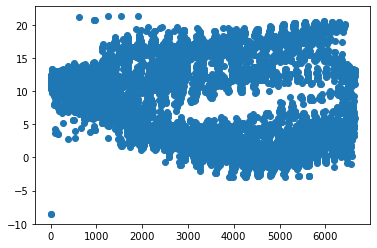

In [82]:
plt.scatter(np.arange(U1.size), U1)

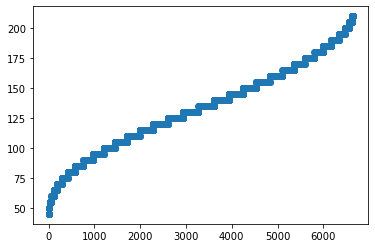

In [79]:
plt.scatter(np.arange(X.size), X)

X:
 Obs      : 8.78898e-09
 Variogram: 4.41000e-01

Y:
 Obs      : 4.86492e-93
 Variogram: 0.00000e+00

Z:
 Obs      : 8.58334e-291
 Variogram: 0.00000e+00



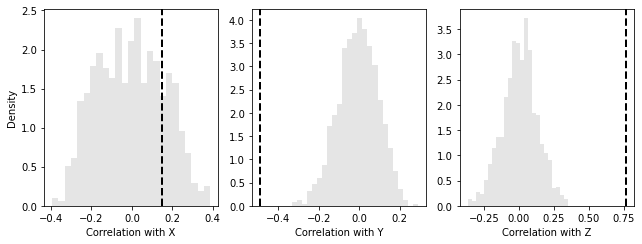

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3.5))

feats = {'X': X, 'Y': Y, 'Z':Z}
rand = {'X': X_surrogates, 'Y': Y_surrogates, 'Z': Z_surrogates}
pv_obs=1
for k, (fn, data) in enumerate(rand.items()):
    r_obs,pv_obs = spearmanr(feats[fn], U1, nan_policy='omit')

    # Compute perm pval
    r_rand = np.asarray([spearmanr(U1, d)[0] for d in data])
    pv_rand = np.mean(np.abs(r_rand) >= np.abs(r_obs))

    # Plot null dist
    axs[k].hist(r_rand, bins=25, density=True, alpha=0.5, color=(.8, .8, .8))
    axs[k].axvline(r_obs, lw=2, ls='--', color='k')
    axs[k].set_xlabel(f'Correlation with {fn}')
    if k == 0:
        axs[k].set_ylabel('Density')

    print(f'{fn.capitalize()}:\n Obs      : {pv_obs:.5e}\n '
          f'Variogram: {pv_rand:.5e}\n')

fig.tight_layout()
plt.show()
fig.savefig("variagram_U1_amyg_ero5_1sd")

In [4]:
import matplotlib as plt
fig, axs = plt.subplots(1, 3, figsize=(9, 3.5))
os.chdir(figDir)
feats = {'X': X, 'Y': Y, 'Z':Z}
rand = {'X': X_surrogates, 'Y': Y_surrogates, 'Z': Z_surrogates}
#pv_obs=1
for k, (fn, data) in enumerate(rand.items()):
    r_obs,pv_obs = spearmanr(feats[fn], U2, nan_policy='omit')

    # Compute perm pval
    r_rand = np.asarray([spearmanr(U2, d)[0] for d in data])
    pv_rand = np.mean(np.abs(r_rand) >= np.abs(r_obs))

    # Plot null dist
    weights = np.ones_like(r_rand) / (len(r_rand))
    nx, xbins, ptchs = axs[k].hist(r_rand, bins=25,weights=weights, alpha=0.5, color=(.8, .8, .8))
    plt.clf() # Get rid of this histogram since not the one we want.
    nx_frac = nx/float(len(nx)) # Each bin divided by total number of objects.
    width = xbins[1] - xbins[0] # Width of each bin.
    x = np.ravel(zip(xbins[:-1], xbins[:-1]+width))
    y = np.ravel(zip(nx_frac,nx_frac))

    axs[k].plot(x,y,linestyle="dashed",label="MyLabel")
    axs[k].axvline(r_obs, lw=2, ls='--', color='k')
    axs[k].set_xlabel(f'Correlation with {fn}')
    if k == 0:
        axs[k].set_ylabel('Density')
    print(f'{fn.capitalize()}:\n Obs      : {pv_obs:.5e}\n '
          f'Variogram: {pv_rand:.5e}\n')
    plt.gca().set_ylim([0,0.12])

plt.ylim()
fig.tight_layout()
plt.show()

AttributeError: module 'matplotlib' has no attribute 'subplots'